<h1 style="text-align:center">New York City Taxi Trip Duration</h1>

<h3>Load Libraries</h3>

In [5]:
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [27]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3>Load Dataset</h3>

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1458644, 11)
Test set shape: (625134, 9)


<h3>Data exploration</h3>

In [8]:
# Observation of the first 5 elements in the training set
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [9]:
# Check the types or each features
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Analyze missing data 

In [10]:
print(train_df.isnull().sum(), "\n")
print(test_df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64 

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


There's no missing data in both the train and test dataframe

<u>Target Feature</u>

In [18]:
pd.options.display.float_format = '{:,.2f}'.format
train_df['trip_duration'].describe()

count   1,458,644.00
mean          959.49
std         5,237.43
min             1.00
25%           397.00
50%           662.00
75%         1,075.00
max     3,526,282.00
Name: trip_duration, dtype: float64

Let's observe the skewness of the trip duration

In [19]:
train_df['trip_duration'].skew()

343.1639435917362

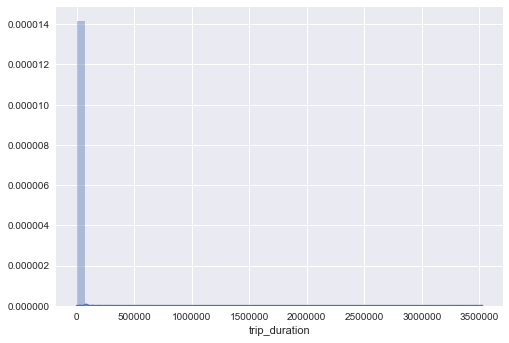

In [24]:
sns.distplot(train_df['trip_duration'])
plt.show()

In regression problems, it is important to look for the skewness of the target feature. <br>
In fact, algorithms such as linear regression or K-Nearest Neighbors are sensitive to the skewness of the data. <br>
The most common correction for a positive skew is to apply <i>the Log transform</i> to have a normally distributed variable.

Skew is: -0.340704230448


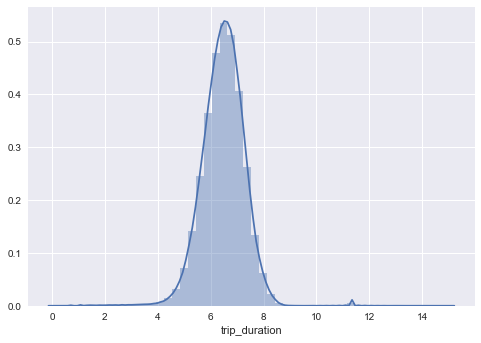

In [25]:
target = np.log(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.show()

Skew is: 12.3297671588


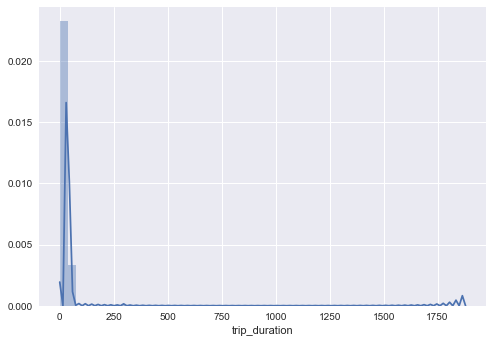

In [26]:
target = np.sqrt(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.show()